# Removing Trends - Lab

## Introduction

In this lab, you'll practice your detrending skills!

## Objectives

You will be able to:
* Learn how to remove trends and seasonality
* Use a log transformation to minimize non-stationarity
* Use rolling means to reduce non-stationarity
* Use differencing to reduce non-stationarity

## Detrending the Airpassenger data

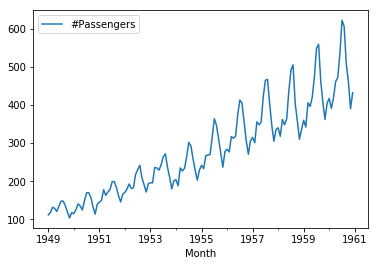

In [4]:
# Import necessary libraries

import pandas as pd
from pandas import Series
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline

# Import passengers.csv and set it as a time-series object. Plot the TS

data = pd.read_csv('./passengers.csv')
ts = data.set_index('Month')
ts.index = pd.to_datetime(ts.index)
ts.plot()

## Create a stationarity check

At this stage, we can use the code from previous labs to create a function `stationarity_check(ts)` that takes in a time series object and performs stationarity checks including rolling statistics and the Dickey Fuller test. 

We want the output of the function to:
- Plot the original time series along with the rolling mean and rolling standard deviation in one plot
- Output the results of the Dickey-Fuller test

In [7]:
# Create a function to check for the stationarity of a given timeseries using rolling stats and DF test
# Collect and package the code from previous lab
def stationarity_check(ts):
    from statsmodels.tsa.stattools import adfuller
    
    #Determine rolling statistics

    rolmean = ts.rolling(window = 12, center = False).mean()
    rolstd = ts.rolling(window = 12, center = False).std()
    
    #Plot rolling statistics
    
    fig = plt.figure(figsize=(12,6))
    orig = plt.plot(ts, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(ts['#Passengers'])

    # Extract and display test results in a user friendly manner
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)


Use your newly created function on the airpassenger data set.

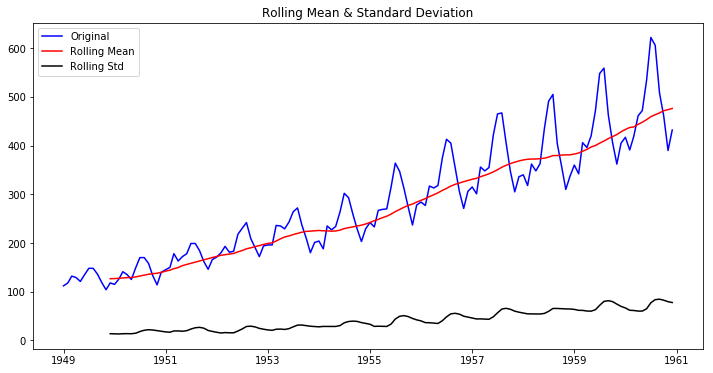

Results of Dickey-Fuller Test:
Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


In [8]:
# Code here
stationarity_check(ts)

## Perform a log() and sqrt() transform

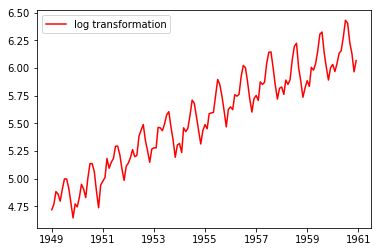

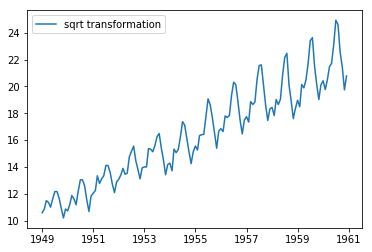

In [14]:
# Log transform timeseries and compare with original to check the effect
log_ts = np.log(ts)
sqrt_ts = np.sqrt(ts)
fig = plt.figure()
plt.plot(log_ts,label = 'log transformation', color = 'red')
plt.legend()
fig = plt.figure()
plt.plot(sqrt_ts, label = 'sqrt transformation')
plt.legend()

moving forward, let's keep working with the log transformed data before subtracting rolling mean, differencing, etc.

## Subtracting the rolling mean

Create a rolling mean using your log transformed time series, with a time window of 7. Plot the log-transformed time series and the rolling mean together.

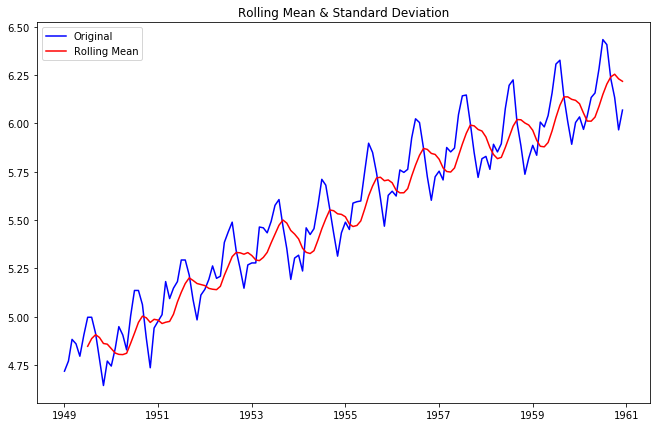

In [18]:
# your code here
rolmean = log_ts.rolling(window = 7).mean()
fig = plt.figure(figsize=(11,7))
orig = plt.plot(log_ts, color='blue',label='Original')
mean = plt.plot(rolmean, color='red', label='Rolling Mean')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

Now, subtract the rolling mean from the time series, look at the 10 first elements of the result and plot the result.

In [20]:
# Subtract the moving average from the original data and check head for Nans
data_minus_rolmean = log_ts - rolmean
data_minus_rolmean.head(15)

,#Passengers
Month,
1949-01-01,NaN
1949-02-01,NaN
1949-03-01,NaN
1949-04-01,NaN
1949-05-01,NaN
1949-06-01,NaN
1949-07-01,0.150059
1949-08-01,0.110242
1949-09-01,0.005404


In [21]:
# Drop the NaN values from timeseries calculated above
data_minus_rolmean.dropna(inplace=True)

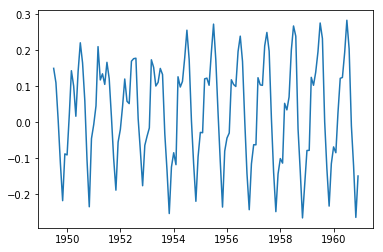

In [22]:
# Plot the result
fig = plt.figure()
plt.plot(data_minus_rolmean)

Finally, use your function `check_stationarity` to see if this series is considered stationary!

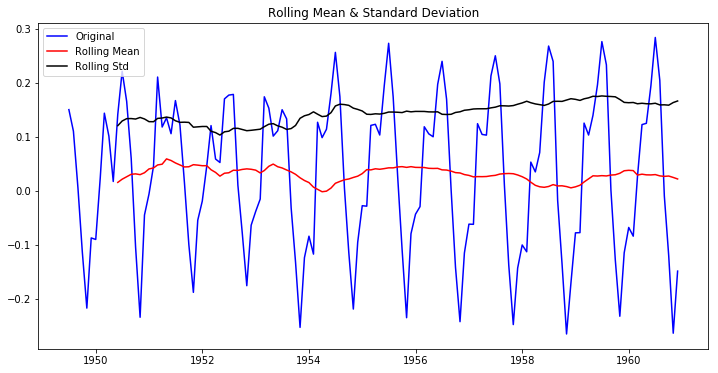

Results of Dickey-Fuller Test:
Test Statistic                  -2.348027
p-value                          0.156946
#Lags Used                      14.000000
Number of Observations Used    123.000000
Critical Value (1%)             -3.484667
Critical Value (5%)             -2.885340
Critical Value (10%)            -2.579463
dtype: float64


In [24]:
# Your code here
stationarity_check(data_minus_rolmean)

### Based on the visuals and on the Dickey-Fuller test, what do you conclude?
The data is still not stationary (p-value above 0.05)

## Subtracting the weighted rolling mean

Repeat all the above for the *weighter* rolling mean. Start from the log-transformed data again. Compare the Dickey-Fuller Test results. What do you conclude?

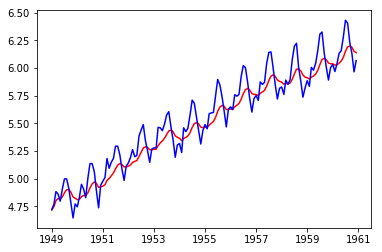

In [29]:
# Use Pandas ewma() to calculate Weighted Moving Average of ts_log
exp_rolmean = log_ts.ewm(halflife = 4).mean()
# Plot the original data with exp weighted average
fig = plt.figure()
plt.plot(exp_rolmean, color = 'red', label = 'weighted rolling mean')
plt.plot(log_ts, color = 'blue', label = 'log transform')

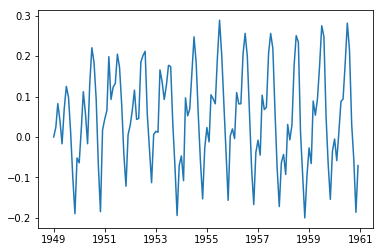

In [30]:
# Subtract the moving average from the original data and plot
minus_exp_rm = log_ts - exp_rolmean
fig = plt.figure()
plt.plot(minus_exp_rm)

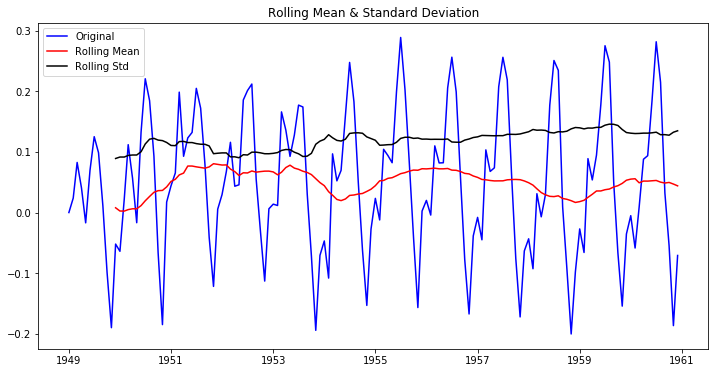

Results of Dickey-Fuller Test:
Test Statistic                  -3.297250
p-value                          0.015002
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


In [31]:
# do a stationarity check
stationarity_check(minus_exp_rm)

### Based on the visuals and on the Dickey-Fuller test, what do you conclude?
The data is stationary, but it still has seasonality.

## Differencing

Using exponentially weighted moving averages, we seem to have removed the upward trend, but not the seasonality issue. Now use differencing to remove seasonality. Make sure you use the right amount of `periods`. Start from the log-transformed, exponentially weighted rolling mean-subtracted series.

After you differenced the series, run the `stationarity check` again.

In [32]:
# difference your data and look at the head
data_diff = minus_exp_rm.diff(periods=12)
data_diff.head(10)



,#Passengers
Month,
1949-01-01,NaN
1949-02-01,NaN
1949-03-01,NaN
1949-04-01,NaN
1949-05-01,NaN
1949-06-01,NaN
1949-07-01,NaN
1949-08-01,NaN
1949-09-01,NaN


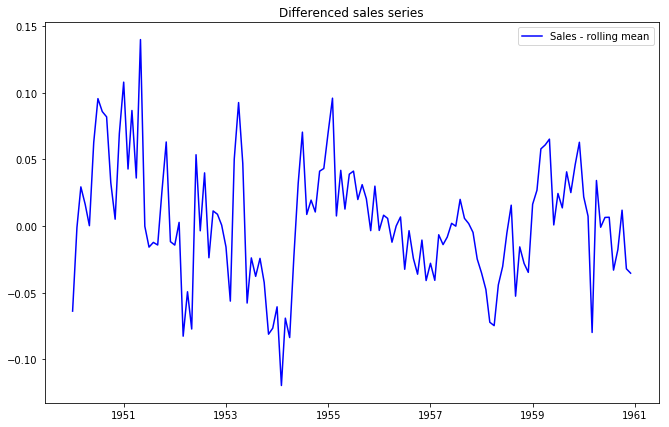

In [33]:
# plot your differenced time series
fig = plt.figure(figsize=(11,7))
plt.plot(data_diff, color='blue',label='Sales - rolling mean')
plt.legend(loc='best')
plt.title('Differenced sales series')
plt.show(block=False)

In [34]:
# drop nas
data_diff.dropna(inplace = True)

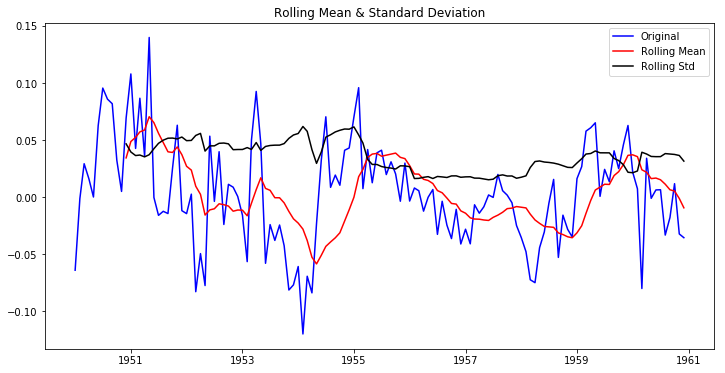

Results of Dickey-Fuller Test:
Test Statistic                  -3.601666
p-value                          0.005729
#Lags Used                      12.000000
Number of Observations Used    119.000000
Critical Value (1%)             -3.486535
Critical Value (5%)             -2.886151
Critical Value (10%)            -2.579896
dtype: float64


In [35]:
# perform the stationarity check
stationarity_check(data_diff)

### Your conclusion
The data isn't completely stationary, but there is no longer seasonality or trends.

## Summary 

In this lab, you learned how to make time series stationary through using log transforms, rolling means and differencing.